In [3]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F
import medmnist
from medmnist import INFO, Evaluator

In [12]:
data_flag = 'bloodmnist'

download = True
NUM_EPOCHS = 20
BATCH_SIZE = 64
lr = 0.005

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

print(n_channels)
print(n_classes)
DataClass = getattr(medmnist, info['python_class'])

3
8


In [13]:
#preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

In [14]:
#load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download,
                          root='/home/shenhaoyu/dataset/pytorch_datasets')
test_dataset = DataClass(split='test', transform=data_transform, download=download,
                         root='/home/shenhaoyu/dataset/pytorch_datasets')

# pil_dataset = DataClass(split='train', download=download)

Using downloaded and verified file: /home/shenhaoyu/dataset/pytorch_datasets/bloodmnist.npz


Using downloaded and verified file: /home/shenhaoyu/dataset/pytorch_datasets/bloodmnist.npz


In [15]:
# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


# print(train_loader[0])
for a,b in train_loader:
    print(a.shape)
    print(b.shape)
    break

torch.Size([64, 3, 28, 28])
torch.Size([64, 1])


In [16]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: /home/shenhaoyu/dataset/pytorch_datasets
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3

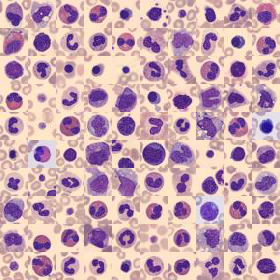

In [17]:
train_dataset.montage(length=10)

In [18]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0):
        super(Block, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = Block(in_channels, 16, kernel_size=3)
        self.layer2 = nn.Sequential(
            Block(16, 16, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = Block(16, 64, kernel_size=3)
        self.layer4 = Block(64, 64, kernel_size=3)
        self.layer5 = nn.Sequential(
            Block(64, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

#Used Softmax for multi-class classification
        if task != "multi-label, binary-class":
            self.fc.add_module("softmax", nn.Softmax(dim=-1))

    def _forward_features(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)

#define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)


In [20]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

train_accuracies = []
test_accuracies = []
train_losses = [] 
test_losses = []  
epoch_times = []

#Training loop
for epoch in range(NUM_EPOCHS):
    start_time = time.time()  

    train_loss = 0.0
    train_correct = 0
    train_total = 0

    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
#Forward pass
        outputs = model(inputs)

#Compute loss
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
        else:
            targets = targets.squeeze().long()

        loss = criterion(outputs, targets)

#Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#Update training statistics
        train_loss += loss.item()

        if task != 'multi-label, binary-class':
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()
        else:
            predicted = (torch.sigmoid(outputs) > 0.5).to(torch.float32)
            train_total += targets.size(0) * targets.size(1)
            train_correct += accuracy_score(targets.cpu().numpy(), predicted.cpu().numpy(), average='micro') * targets.size(0)

#Calculate training accuracy after each epoch
    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss / len(train_loader))  # to store training loss

#Validation loop
    model.eval()
    test_correct = 0
    test_total = 0
    test_loss = 0.0  

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.sigmoid()
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)

                _, predicted = torch.max(outputs.data, 1)
                test_total += targets.size(0)
                test_correct += (predicted == targets).sum().item()

#Compute validation loss
                loss = criterion(outputs, targets)
                test_loss += loss.item()

#Calculate validation accuracy after each epoch
    test_accuracy = 100 * test_correct / test_total
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss / len(test_loader))  # Store validation loss

# Record the end time of the epoch
    end_time = time.time()
    epoch_times.append(end_time - start_time)

#Print epoch summary
    print(f'Training Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {train_loss / len(train_loader):.4f}, '
          f'Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {test_accuracy:.2f}, '
          f'Time: {end_time - start_time:.2f} seconds')

#Plotting
epochs = range(1, NUM_EPOCHS + 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Analysis')
plt.legend()
plt.show()


Training Epoch [1/20], Loss: 1.8612, Training Accuracy: 44.06%, Validation Accuracy: 63.11, Time: 16.90 seconds
Training Epoch [2/20], Loss: 1.5909, Training Accuracy: 69.45%, Validation Accuracy: 73.46, Time: 17.20 seconds


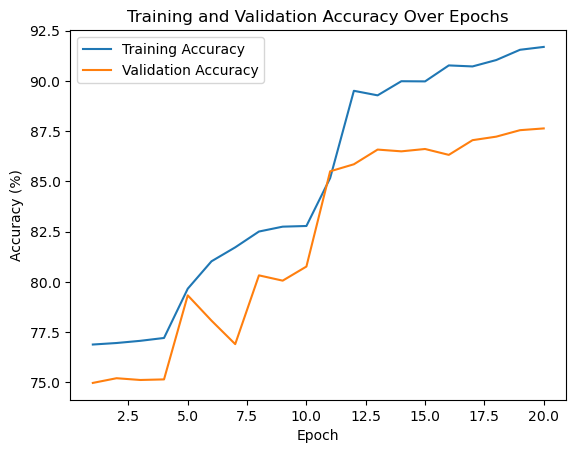

In [16]:
#Plotting
epochs = range(1, NUM_EPOCHS + 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

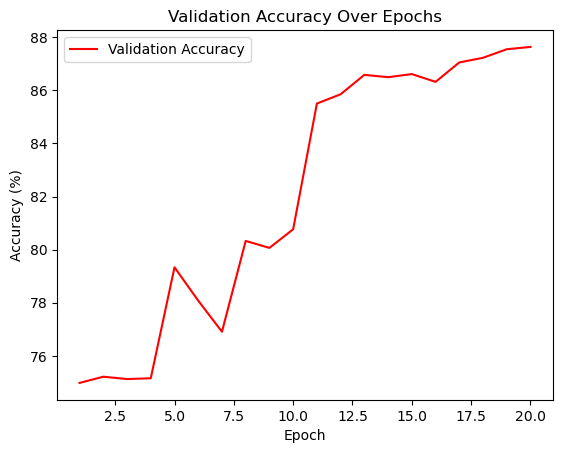

In [17]:
# Plotting
epochs = range(1, NUM_EPOCHS + 1)

plt.plot(epochs, test_accuracies, label='Validation Accuracy',color= 'red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

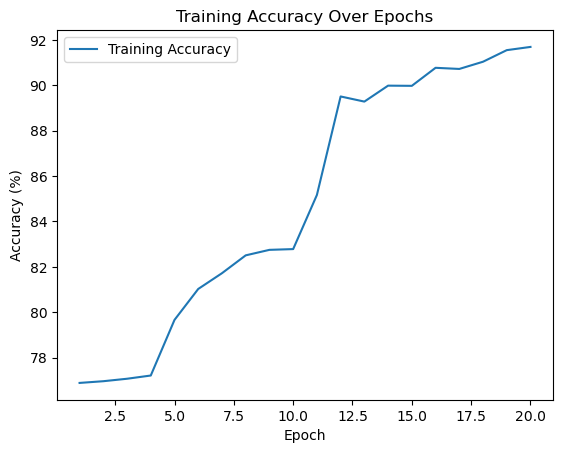

In [18]:
# Plotting
epochs = range(1, NUM_EPOCHS + 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()